# Prepare
## load necessary pacakges

In [1]:
import sys
import os 

sys.path.append('/data/yosef2/users/chenling/scVI/')
sys.path.append('/data/yosef2/users/chenling/tabula-sapiens/')
import anndata

from scvi.dataset import AnnDatasetFromAnnData
from utils.annotations_utils import *
from anndata import read_h5ad
import scanpy as sc

retrain=False

import matplotlib
%matplotlib inline
from copy import deepcopy

In [2]:
from copy import deepcopy

## set directories for reading and saving results

In [3]:
data_path = '/data/yosef2/users/chenling/TabulaSapiensData/'
model_path = '/data/yosef2/users/chenling/TabulaSapiens/scVImodels/'

## Read in data

In [4]:
combined = read_h5ad(data_path + 
                     'combined/Pilot1_Pilot2_filtered_ensembl_id.june30.ss2_norm.embedding_donor_tech.h5ad')

# Seed labels

**Epithelial**: CDH1,  CLDN4,  EPCAM

**Endothelial**: CA4, CDH5, CLDN5, PECAM1, VWF,

**Stromal**: BGN, DCN, COL1A2,

**Immune**: LCP1, PTPRC, RAC2 

In cellxgene to label compartments by selecting cells that are positive for all the compartment specific markers, and negative for all the other compartment markers 
### This is the list of genes that can be copied to the bulk add genes section of cellxgene
CDH1,  CLDN4,  EPCAM, CA4, CDH5, CLDN5, PECAM1, VWF,BGN, DCN, COL1A2,LCP1, PTPRC, RAC2 

# compartment annotation

In [5]:
compartment_ann = pd.read_csv(data_path + 'combined/compartmentseeds_no_low_quality.csv', index_col=0, skiprows=2)
compartment_ann.index = [x.split('-')[0] for x in compartment_ann.index]

In [6]:
unique, count = np.unique(compartment_ann.index, return_counts=True)
unique = unique[count==1]
compartment_ann = compartment_ann.loc[unique]

In [7]:
temp = [x.split('-')[0] for x in combined.obs.index]

In [8]:
combined.obs['compartment'] = compartment_ann.loc[temp, 'Compartment'].values
combined.obs['compartment'].fillna('unassigned', inplace=True)

### Only a small number of cells are annotated using markers. These labelled cells are used as training data for scANVI to automatically classify other organs

In [9]:
np.unique(combined.obs['compartment'], return_counts=True)

(array(['Endothelial', 'Epithelial', 'Immune', 'Stromal', 'unassigned'],
       dtype=object), array([  1057,    473,    884,   1291, 199808]))

In [11]:
train_data = scVIdata_preprocess(combined, batch_col='donor_tech', label_col='compartment')

[2020-07-02 17:57:25,681] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-02 17:57:25,693] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-02 17:57:37,055] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-02 17:57:38,477] INFO - scvi.dataset.dataset | Downsampled from 203513 to 203513 cells


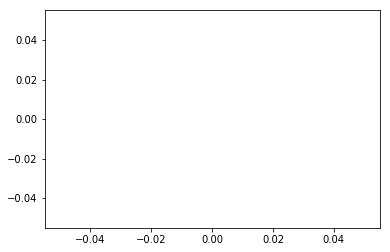

In [12]:
posterior = get_scvi_posterior(train_data, 
                               model_path+'Pilot12.all-minus-fat-heart.donor_tech.50.3.ss2_norm.scVI.pkl',
                               retrain=retrain, n_latent=50, n_layers=3)

full, pred_celltype = scanvi_pred(train_data, 
                                  model_path+'Pilot12.all-minus-fat-heart.donor_tech.50.3.ss2_norm.scVI.pkl',
                                  model_path+'Pilot12.all-minus-fat-heart.donor_tech.50.3.ss2_norm.scANVI.compartment.2.pkl',
                                  nlabels=500, retrain=retrain)

pred_celltype = np.asarray([train_data.cell_types[x] for x in pred_celltype])

run DE between 10x and ss2 just to check 
combined.obs['method'].values=='10X'
posterior.gene_dataset.X.shape
tech_DE = posterior.differential_expression_score(combined.obs['method'].values=='10X', combined.obs['method'].values=='smartseq2',
                                         mode='change')

In [13]:
combined.obs['compartment_pred'] = pred_celltype

In [14]:
combined.write_h5ad(data_path + 'combined/Pilot1_Pilot2_filtered_ensembl_id.june30.embedding.compartment.2.h5ad')

... storing 'compartment' as categorical
... storing 'compartment_pred' as categorical


In [15]:
combined = read_h5ad(data_path + 'combined/Pilot1_Pilot2_filtered_ensembl_id.june30.embedding.compartment.h5ad')

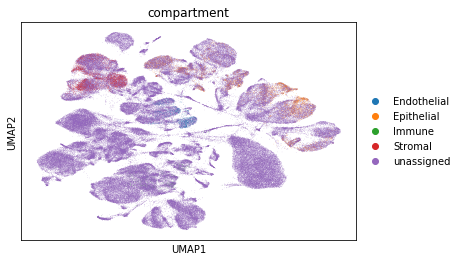

In [16]:
sc.pl.umap(combined, color=['compartment'])

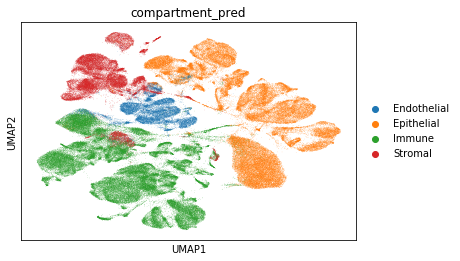

In [17]:
sc.pl.umap(combined, color=['compartment_pred'])

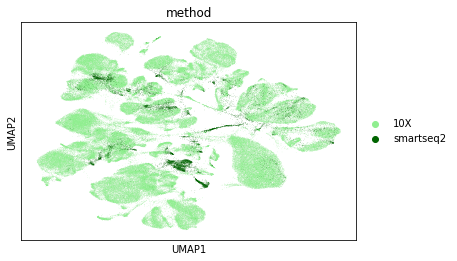

In [18]:
sc.pl.umap(combined, color=['method'])

# add annotations

In [8]:
annotation = pd.read_csv(data_path + 'combined/annotation.subsample_genes.csv')
assert combined.shape[0] == annotation.shape[0]
assert np.sum(annotation['cell_id'].values == combined.obs['cell_id'].values) == combined.shape[0]

In [20]:
combined.obs['propagated_cell_ontology_class'] = annotation['propagated_cell_ontology_class'].values
combined.obs['manual_cell_ontology_class'] = annotation['manual_cell_ontology_class'].values

In [21]:
annotation = pd.read_csv(data_path + 'combined/annotation.csv')
assert combined.shape[0] == annotation.shape[0]
assert np.sum(annotation['cell_id'].values == combined.obs['cell_id'].values) == combined.shape[0]

In [22]:
combined.obs['propagated_cell_ontology_class_0'] = annotation['propagated_cell_ontology_class'].values
combined.obs['manual_cell_ontology_class_0'] = annotation['manual_cell_ontology_class'].values

In [35]:
combined.raw = deepcopy(combined)

In [36]:
sc.pp.normalize_total(combined, target_sum=1e4)
sc.pp.log1p(combined)

In [37]:
gene_cols = [x for x in combined.var.columns if 'gene_symbol' in x]
assert np.sum(combined.var[gene_cols[0]] == combined.var[gene_cols[1]]) == len(combined.var[gene_cols[0]])

In [38]:
combined.var['ensemble_id'] = combined.var.index
combined.var.index = combined.var['gene_symbol-0-0']
combined.var.index.name = None

In [39]:
combined.write_h5ad(data_path + 'combined/Pilot1_Pilot2.Final.h5ad')

# write to compartments

In [40]:
temp = combined[combined.obs['compartment_pred']=='Endothelial']
sc.pp.neighbors(temp, n_neighbors=50, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(temp)
temp.write_h5ad(data_path + 'combined/Pilot1_Pilot2.Final.Endothelial.h5ad')

In [41]:
temp = combined[combined.obs['compartment_pred']=='Epithelial']
sc.pp.neighbors(temp, n_neighbors=50, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(temp)
temp.write_h5ad(data_path + 'combined/Pilot1_Pilot2.Final.Epithelial.h5ad')

In [42]:
temp = combined[combined.obs['compartment_pred']=='Immune']
sc.pp.neighbors(temp, n_neighbors=50, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(temp)
temp.write_h5ad(data_path + 'combined/Pilot1_Pilot2.Final.Immune.h5ad')

In [43]:
temp = combined[combined.obs['compartment_pred']=='Stromal']
sc.pp.neighbors(temp, n_neighbors=50, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(temp)
temp.write_h5ad(data_path + 'combined/Pilot1_Pilot2.Final.Stromal.h5ad')

# split compartment by celltypes
Alternatively, we can split compartment by cell type predictions

In [12]:
celltype_compart = {}
celltype_compart['Endothelial'] = ['capillary endothelial cell',
                'endothelial cell', 'endothelial cell of artery',
                'endothelial cell of lymphatic vessel',
                'endothelial cell of vascular tree',  'lung microvascular endothelial cell',
                'vein endothelial cell']
celltype_compart['Stromal'] = ['adventitial cell', 'fast muscle cell', 'fibroblast',
                'fibroblast of lung', 'mesenchymal cell','mesenchymal stem cell',
                'multi-potent skeletal muscle stem cell','myoblast', 'myofibroblast cell',
                'pericyte cell', 'pancreatic stellate cell','skeletal muscle fiber', 
                'slow muscle cell', 'smooth muscle cell','vascular associated smooth muscle cell',
                'stromal cell', 'tendon cell',]
celltype_compart['Epithelial'] = ['basal cell','bladder urothelial cell','ciliated cell',
                'club cell','enterocyte','enterocyte of epithelium of small intestine',
                'enteroendocrine cell', 'epithelial cell','epithelial cell of alveolus of lung',  
                'goblet cell','intermediate epitheliocyte','intestinal crypt stem cell',
                'ionocyte', 'kidney epithelial cell', 'large intestine crypt goblet cell',
                'lung ciliated cell','medullary thymic epithelial cell', 'pancreatic A cell',
                'pancreatic acinar cell','pancreatic ductal cell','paneth cell',
                'respiratory goblet cell', 'secretory cell','type B pancreatic cell',
                'type I pneumocyte', 'type II pneumocyte', ]
celltype_compart['Immune'] = ['B cell',
                'CD34-positive, CD38-negative multipotent progenitor cell',
                'CD4-positive helper T cell', 'CD4-positive, alpha-beta T cell',
                'CD4-positive, alpha-beta memory T cell',
                'CD8-positive, alpha-beta T cell',
                'CD8-positive, alpha-beta memory T cell', 'DN1 thymic pro-T cell',
                'Langerhans cell', 'T cell', 'T follicular helper cell',
                'T-helper 17 cell','activated CD8-positive, alpha-beta T cell, human',
                'basophil','classical monocyte', 
                'conventional dendritic cell', 'cytotoxic T cell',
                'dendritic cell, human', 'double negative thymocyte',
                'effector memory CD4-positive, alpha-beta T cell',
                'effector memory CD8-positive, alpha-beta T cell',
                'erythrocyte','erythroid progenitor cell',
                'follicular B cell','granulocyte', 'group 3 innate lymphoid cell',
                'hematopoietic stem cell','intermediate monocyte',  
                'lymphocyte', 'macrophage', 'mast cell', 'mature NK T cell',
                'megakaryocyte','memory B cell', 'memory T cell',
                'monocyte','myeloid cell','naive B cell',
                'naive thymus-derived CD4-positive, alpha-beta T cell',
                'naive thymus-derived CD8-positive, alpha-beta T cell',
                'natural killer cell', 'neutrophil', 'non-classical monocyte',
                'plasma cell','plasmacytoid dendritic cell','plasmacytoid dendritic cell, human',
                'platelet', 'pro-B cell',]

In [45]:
annotation = pd.read_csv(data_path + 'Pilot1_Pilot2.annotation.csv')

In [47]:
tissue_celltypes  = {}

In [48]:
for x in np.unique(annotation['tissue']):
    celltypes = np.unique(annotation.loc[annotation['tissue']==x, 'manual_cell_ontology_class'])
    celltypes = celltypes[celltypes!='unassigned']
    tissue_celltypes[x] = celltypes

In [117]:
tissue_specific = {}
tissue_specific['Bladder'] = ['bladder urothelial cell']
tissue_specific['Blood'] = []
tissue_specific['Lymph_Node'] = []
tissue_specific['Spleen'] = []
tissue_specific['Trachea'] = ['ciliated cell','secretory cell']
tissue_specific['Vasculature'] = []
tissue_specific['Bone_Marrow'] = ['CD34-positive, CD38-negative multipotent progenitor cell',
                                 'early lymphoid progenitor', 'erythroid progenitor cell',
                                 'hematopoietic stem cell']
tissue_specific['Kidney'] = ['kidney epithelial cell']
tissue_specific['Large_Intestine'] = ['enterocyte',
       'enteroendocrine cell', 'goblet cell',
       'intestinal crypt stem cell', 'large intestine crypt goblet cell','secretory cell']
tissue_specific['Lung'] = [ 'adventitial cell','bronchial smooth muscle cell', 'club cell','fibroblast of lung',
       'ionocyte', 'lung ciliated cell','lung microvascular endothelial cell','respiratory goblet cell',
       'serous cell of epithelium of bronchus', 'type I pneumocyte','type II pneumocyte','ciliated cell',
        'epithelial cell of alveolus of lung','secretory cell']
tissue_specific['Muscle'] = [ 'mesenchymal stem cell','skeletal muscle fiber','tendon cell','mesenchymal cell',
       'multi-potent skeletal muscle stem cell', 'slow muscle cell', 'fast muscle cell']
tissue_specific['Pancreas'] = ['pancreatic A cell', 'pancreatic D cell', 'pancreatic acinar cell',
       'pancreatic ductal cell', 'pancreatic stellate cell',
       'type B pancreatic cell','secretory cell']
tissue_specific['Skin'] = ['Langerhans cell','melanocyte']
tissue_specific['Small_Intestine'] = ['enterocyte',
       'enterocyte of epithelium of small intestine',
       'enteroendocrine cell', 'goblet cell',
       'intestinal crypt stem cell', 'paneth cell','secretory cell']
tissue_specific['Thymus'] = [
       'CD8-alpha-alpha-positive, alpha-beta intraepithelial T cell','DN1 thymic pro-T cell',
       'double negative thymocyte','resting double-positive thymocyte','medullary thymic epithelial cell']

In [118]:
a = []
for x in tissue_celltypes.keys():
    a+=list(tissue_celltypes[x])

In [119]:
b = []
for x in tissue_specific.keys():
    b+=list(tissue_specific[x])

In [120]:
a = [x for x in a if x not in b]

In [121]:
c,d = np.unique(b,return_counts=True)
temp = pd.DataFrame([c,d]).T

In [122]:
temp[temp[1]>1]

,0,1
7,ciliated cell,2
11,enterocyte,2
13,enteroendocrine cell,2
18,goblet cell,2
20,intestinal crypt stem cell,2
39,secretory cell,5


In [123]:
c,d = np.unique(a,return_counts=True)
temp = pd.DataFrame([c,d]).T

In [127]:
list(temp[temp[1]<=2][0])

['CD4-positive, CD25-positive, alpha-beta regulatory T cell',
 'CD4-positive, alpha-beta T cell',
 'CD4-positive, alpha-beta cytotoxic T cell',
 'CD8-positive, alpha-beta memory T cell',
 'T-helper 17 cell',
 'activated CD8-positive, alpha-beta T cell, human',
 'capillary endothelial cell',
 'cytotoxic T cell',
 'effector memory CD4-positive, alpha-beta T cell',
 'effector memory CD8-positive, alpha-beta T cell',
 'endothelial cell of lymphatic vessel',
 'endothelial cell of vascular tree',
 'epithelial cell',
 'follicular B cell',
 'granulocyte',
 'group 3 innate lymphoid cell',
 'intermediate epitheliocyte',
 'lymphocyte',
 'megakaryocyte',
 'memory T cell',
 'monocyte',
 'myeloid cell',
 'myeloid dendritic cell, human',
 'myofibroblast cell',
 'naive thymus-derived CD8-positive, alpha-beta T cell',
 'pericyte cell',
 'plasmacytoid dendritic cell, human',
 'platelet',
 'pro-B cell',
 'regulatory T cell',
 'stromal cell',
 'vein endothelial cell']

In [128]:
# np.unique(annotation.loc[annotation['manual_cell_ontology_class']=='myoblast','tissue'])

In [129]:
for x in tissue_specific.keys():
    tissue_celltypes[x] = tissue_specific[x] + a

In [132]:
import pickle as pkl
pkl.dump((tissue_celltypes, tissue_specific), open(data_path + "tissue_celltypes.pkl", 'wb'))

In [133]:
data_path

'/data/yosef2/users/chenling/TabulaSapiensData/'